# Проект: Отток клиентов банка

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно.
Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.
 Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением *F1*-меры.
 Нужно довести метрику до 0.59. Проверить *F1*-меру на тестовой выборке.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### План работ  

#### Шаг 1. Откроем, изучим и подготовим данные  

#### Шаг 2. Исследуем задачу  

#### Шаг 3. Решим вопрос с дисбалансом 

#### Шаг 4. Протестируем модель  

### Описание данных

#### Признаки

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты  
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата  
  
#### Целевой признак  
  
- Exited — факт ухода клиента

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score,precision_recall_curve,auc,roc_curve
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

# 1. Подготовка данных

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Пропуски есть в столбце Tenure — количество недвижимости у клиента.
Типы данных нормальные.

In [4]:
#проверим данные на наличие дубликатов.
df.duplicated().sum()

0

In [5]:
# количество NaN в Tenure
df['Tenure'].isnull().sum()

909

In [6]:
# удалим их
df.drop(df[df['Tenure'].isnull() == True].index,inplace=True)

In [7]:
# теперь NaN нет в Tenure
df['Tenure'].isnull().sum()

0

### Проанализируем данные и проверим на выбросы

In [8]:
df.groupby('Exited')['CustomerId'].count()

Exited
0    7237
1    1854
Name: CustomerId, dtype: int64

Дисбаланс классов.

In [9]:
df['CreditScore'].describe()

count    9091.000000
mean      650.736553
std        96.410471
min       350.000000
25%       584.000000
50%       652.000000
75%       717.000000
max       850.000000
Name: CreditScore, dtype: float64

In [10]:
stayed = df[df['Exited'] == 0]
escaped = df[df['Exited'] == 1]

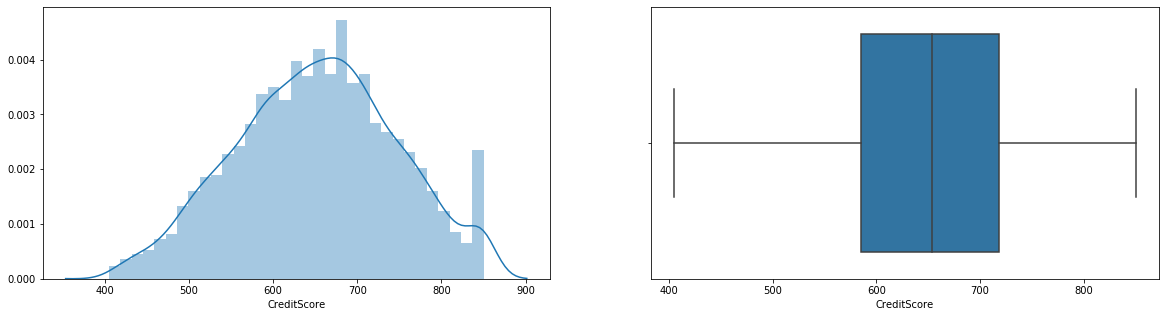

In [11]:
#Построим графики двух тарифов
def dist_and_box(df,col):
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    sns.distplot(df[col],ax=axs[0]);
    sns.boxplot(df[col], ax=axs[1]);
    
# кредитный рейтинг тех кто остался    
dist_and_box(stayed,'CreditScore')

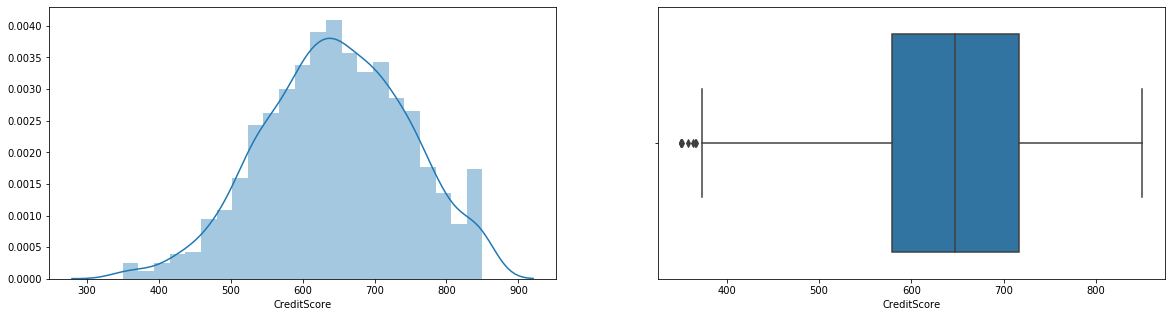

In [12]:
# кредитный рейтинг тех кто ушёл
dist_and_box(escaped,'CreditScore')

In [13]:
# страны с клиентами
df['Geography'].value_counts()

France     4550
Germany    2293
Spain      2248
Name: Geography, dtype: int64

In [14]:
# распределение оставшихся и ушедших по странам
geography = df.pivot_table(index=['Geography'],columns="Exited", values="CreditScore",aggfunc="count")
geography

Exited,0,1
Geography,,
France,3817,733
Germany,1542,751
Spain,1878,370


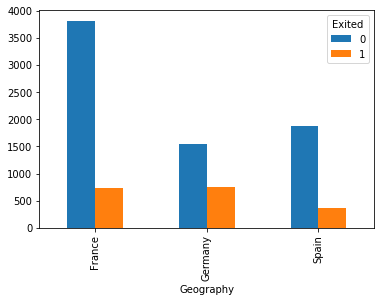

In [15]:
geography.plot(kind='bar');

В Германии больше всего ушедших в соотношении к оставшимся.

In [16]:
df['Gender'].value_counts()

Male      4974
Female    4117
Name: Gender, dtype: int64

In [17]:
gender = df.pivot_table(index=['Gender'],columns="Exited", values="CreditScore",aggfunc="count")
gender

Exited,0,1
Gender,,
Female,3076,1041
Male,4161,813


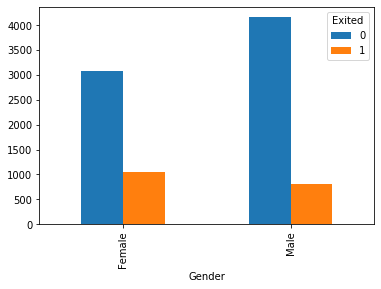

In [18]:
gender.plot(kind='bar');

Мужчин и женщин примерно поровну. 

In [19]:
df['Age'].describe()

count    9091.000000
mean       38.949181
std        10.555581
min        18.000000
25%        32.000000
50%        37.000000
75%        44.000000
max        92.000000
Name: Age, dtype: float64

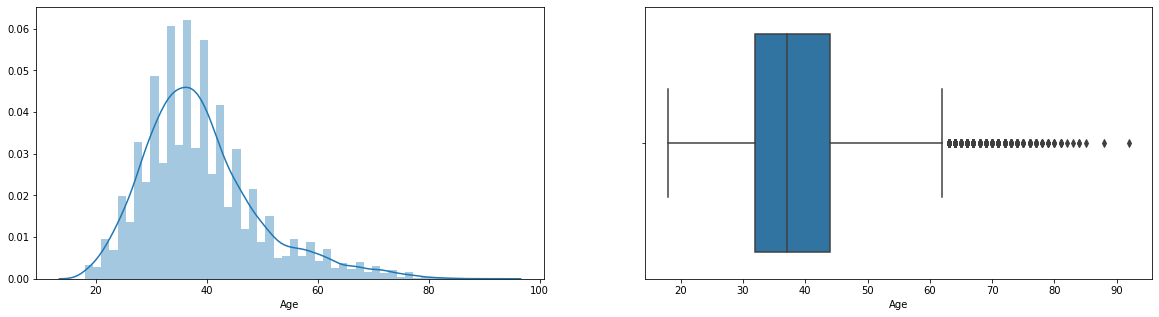

In [20]:
dist_and_box(df,'Age')

Среднее и медиана возраста близки, среднее больше, данные распределены со скосом вправо.

In [21]:
df['Tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

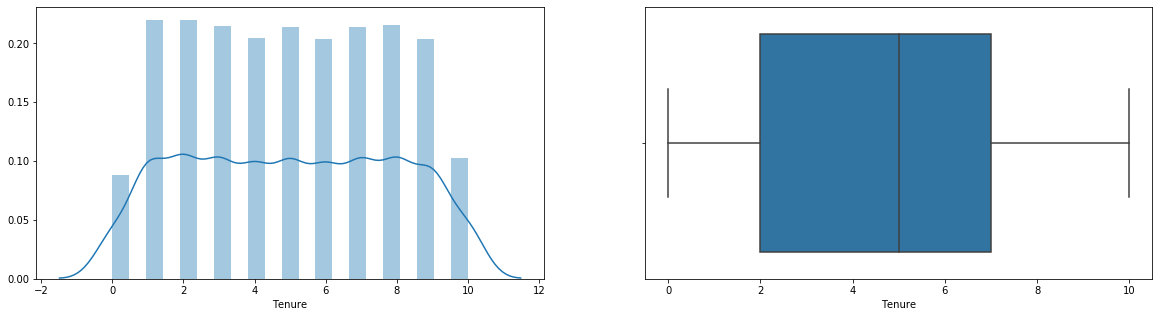

In [22]:
dist_and_box(df,'Tenure')

Среднее и медиана по количеству недвижимости близки, данные распределены нормально.

In [23]:
df['Balance'].describe()

count      9091.000000
mean      76522.740015
std       62329.528576
min           0.000000
25%           0.000000
50%       97318.250000
75%      127561.890000
max      250898.090000
Name: Balance, dtype: float64

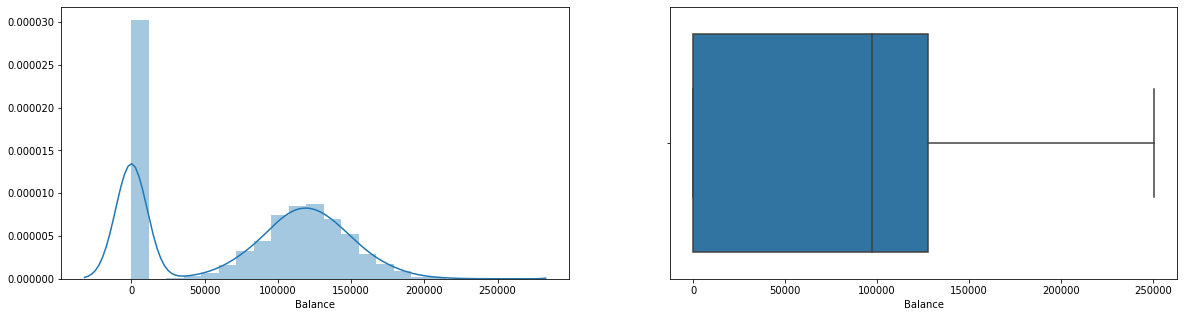

In [24]:
dist_and_box(df,'Balance')

Медиана больше среднего, из-за клиентов с балансом менее 50тыс есть выбрас в районе первого квантиля.

In [25]:
df[df['Balance'] < 50000]['CustomerId'].count()

3348

In [26]:
df[df['Balance'] < 50000].groupby('Exited')['Balance'].count()

Exited
0    2872
1     476
Name: Balance, dtype: int64

Клиенты с низким балансом продолжают оставаться клиентами банка.

In [27]:
df['NumOfProducts'].describe()

count    9091.000000
mean        1.530195
std         0.581003
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: NumOfProducts, dtype: float64

In [28]:
df['HasCrCard'].describe()

count    9091.000000
mean        0.704983
std         0.456076
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: HasCrCard, dtype: float64

In [29]:
df['IsActiveMember'].describe()

count    9091.000000
mean        0.515565
std         0.499785
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IsActiveMember, dtype: float64

In [30]:
df['EstimatedSalary'].describe()

count      9091.000000
mean     100181.214924
std       57624.755647
min          11.580000
25%       51227.745000
50%      100240.200000
75%      149567.210000
max      199992.480000
Name: EstimatedSalary, dtype: float64

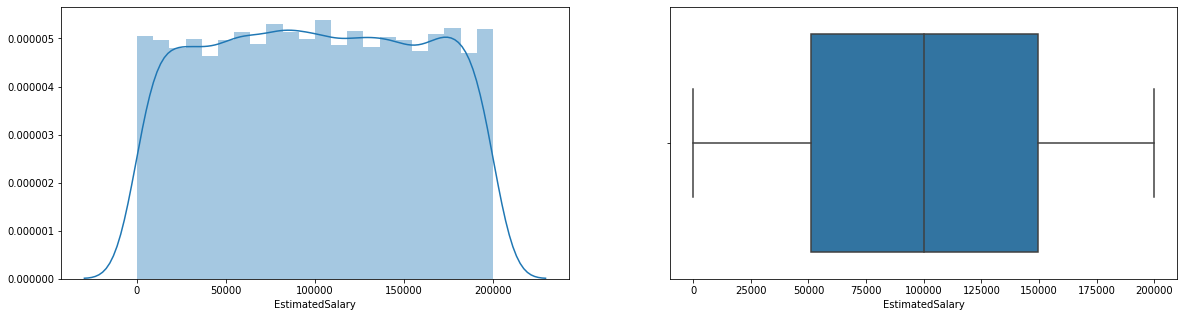

In [31]:
dist_and_box(df,'EstimatedSalary')

In [32]:
df['EstimatedSalary'].sort_values()

2362        11.58
9647        90.07
9010        91.75
5548        96.27
7565       123.07
          ...    
8926    199909.32
9096    199929.17
4417    199953.33
3580    199970.74
6646    199992.48
Name: EstimatedSalary, Length: 9091, dtype: float64

Не понятно можно ли считать зарплату в 11,58 выбрасом, может это какие-то выплаты которые человек получает в Германии.

In [33]:
df[df['EstimatedSalary']==11.58]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2362,2363,15791053,Lucciano,709,Germany,Male,45,4.0,122917.71,1,1,1,11.58,1


Данные впорядке, к остальным столбцам вопросов нет.

##### Посмотрим на корреляцию


In [34]:
#для дальнейших действий оставлю только нужные столбцы для задачи RowNumber,CustomerId,Surname удалю
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.004504,-0.000062,0.002804,0.011090,-0.003937,0.030947,0.005182,-0.023950
Age,-0.004504,1.000000,-0.013134,0.031481,-0.031877,-0.014129,0.082269,-0.007037,0.283017
Tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,0.002804,0.031481,-0.007911,1.000000,-0.301858,-0.019055,-0.003285,0.014351,0.117218
NumOfProducts,0.011090,-0.031877,0.011979,-0.301858,1.000000,0.005805,0.009084,0.013990,-0.050271
HasCrCard,-0.003937,-0.014129,0.027232,-0.019055,0.005805,1.000000,-0.008810,-0.006136,-0.005411
IsActiveMember,0.030947,0.082269,-0.032178,-0.003285,0.009084,-0.008810,1.000000,-0.020049,-0.155062
EstimatedSalary,0.005182,-0.007037,0.010520,0.014351,0.013990,-0.006136,-0.020049,1.000000,0.016029
Exited,-0.023950,0.283017,-0.016761,0.117218,-0.050271,-0.005411,-0.155062,0.016029,1.000000


Возраст и баланс на счете немного коррелируют с уходом клиентов. Чем старше клиент и больше денег на счете, тем выше шанс, что клиент покинет банк. Так же активность коррелирует с уходом. Чем выше тем менее вероятно, что покинет банк.

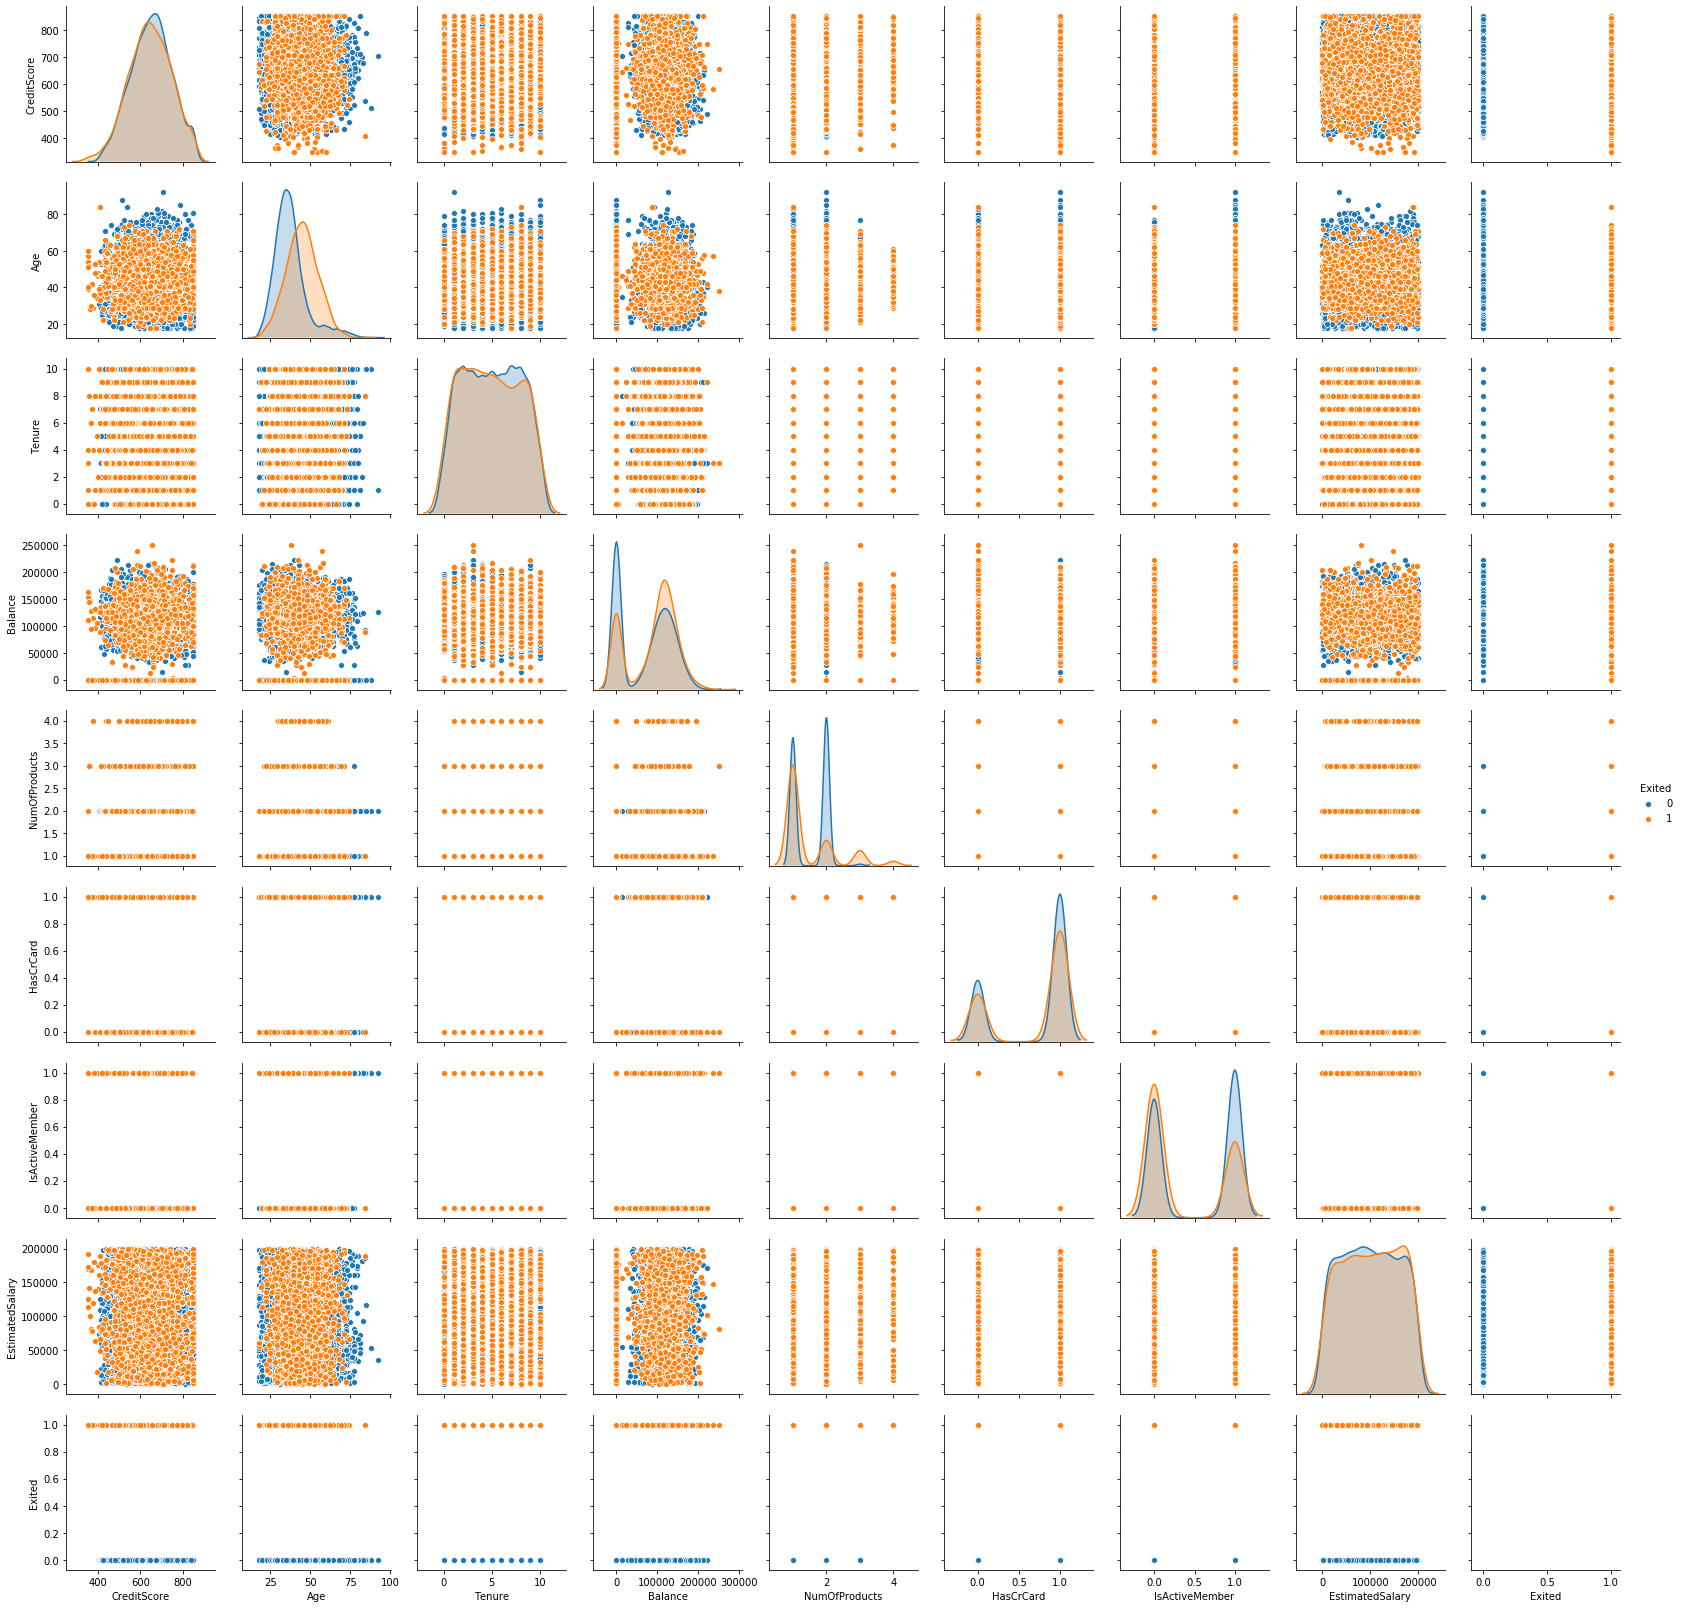

In [35]:
sns.pairplot(data=df, hue = 'Exited');

По графикам видно, что банк покидают клиенты в возрасте, и
клиенты с деньгами. Так же реже покидают у кого в наличии
два продукта банка. И активные члены банка реже покидают банк.

# 2. Исследование задачи

In [36]:
df['Exited'].value_counts()

0    7237
1    1854
Name: Exited, dtype: int64

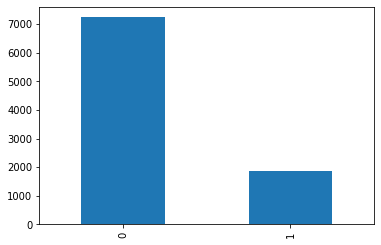

In [37]:
df['Exited'].value_counts().plot(kind='bar');

Тех кто остался больше чем тех кто ушел, нужно будет разобраться с дисбалансом.
Но это потом, пока обучим модель с дисбалансом и сравним с моделью без дисбаланса.

In [38]:
df.head(1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.0,1,1,1,101348.88,1


Теперь закодируем признаки техникой прямого кодирования One-Hot Encoding, OHE

In [39]:
df = pd.get_dummies(df, columns=['Geography', 'Gender'])
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1,1,0


Определение класса это задача классификации.
Будем использовать дерево решений, рендом форест и логистическую регрессию.

С начало делим 60% на 40%. Потом выборку с 40% на пополам по 50%,
получаем по 20% от изначальной выборки.

In [41]:
#разделим данные на тренировочную валидационную и тестовую выборки в соотношении 60/20/20
train, df_valid_test = train_test_split(df, test_size=0.4, random_state=12345)
validate, test = train_test_split(df_valid_test, test_size=0.5, random_state=12345)

In [42]:
print(f'Размер выборки для тренировки: {train.shape}\nРазмер выборки для валидации: {validate.shape}\nРазмер выборки для теста: {test.shape}')


Размер выборки для тренировки: (5454, 14)
Размер выборки для валидации: (1818, 14)
Размер выборки для теста: (1819, 14)


In [43]:
#выделим признаки на тренировочной и валидационной выборках
features_train = train.drop(['Exited'], axis=1)
target_train = train['Exited']

features_valid = validate.drop(['Exited'], axis=1)
target_valid = validate['Exited']

features_test = test.drop(['Exited'], axis=1)
target_test = test['Exited']

Теперь отмасштабируем признаки.

In [44]:
numeric = ['CreditScore', 'Age','Tenure', 'Balance', 'NumOfProducts','HasCrCard',
           'IsActiveMember','EstimatedSalary','Geography_France','Geography_Germany',
           'Geography_Spain','Gender_Female','Gender_Male']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Для примера сделаем ручной перебор параметров в цикле и затем с GridSearchCV.

### Без GridSearchCV

In [45]:
def get_score_decision_tree_classifier(features_train, target_train, step=10):
    roc_auc = 0
    f1 = 0
    max_depth_decision_tree = 1
    for i in range(1,100, step):
        model = DecisionTreeClassifier(random_state=12345, max_depth=i)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1_step = f1_score(target_valid, predicted_valid)
        if f1_step > f1:
            f1 = f1_step
            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
            max_depth_decision_tree = i
            best_model = model
    return f1, roc_auc, max_depth_decision_tree, best_model

f1, roc_auc, max_depth_decision_tree, _ = get_score_decision_tree_classifier(features_train, target_train)         
print('f1_score',f1)        
print('roc_auc_score',roc_auc)     
print('max_depth_decision_tree',max_depth_decision_tree)

f1_score 0.5099236641221374
roc_auc_score 0.7207150575142152
max_depth_decision_tree 11


In [46]:
def get_score_random_forest_classifier(features_train, target_train, step=10):
    roc_auc = 0
    f1 = 0
    n_estimators = 1
    for i in range(1,100, step):
        model = RandomForestClassifier(random_state=12345, n_estimators=i)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1_step = f1_score(target_valid, predicted_valid)
        if f1_step > f1:
            f1 = f1_step
            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
            n_estimators = i
            best_model = model
    return f1, roc_auc, n_estimators, best_model
f1, roc_auc, n_estimators, _ = get_score_random_forest_classifier(features_train, target_train)        
print('f1_score',f1)        
print('roc_auc_score',roc_auc)     
print('n_estimators',n_estimators)

f1_score 0.5831960461285008
roc_auc_score 0.8611117758261744
n_estimators 41


In [47]:
def get_score_logistic_regression(features_train,target_train,class_weight=None,step=0.02):
    f1 = 0
    roc_auc = 0
    threshold = 0

    model = LogisticRegression(random_state=12345, solver='liblinear', class_weight=class_weight)
    model.fit(features_train, target_train)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    for threshold_step in np.arange(0, 0.8, step):
        predicted_valid = probabilities_one_valid > threshold_step
        precision_step = precision_score(target_valid, predicted_valid)
        recall_step = recall_score(target_valid, predicted_valid)
        f1_step = f1_score(target_valid, predicted_valid)
        print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}".format(
            threshold_step, precision_step, recall_step, f1_step))
        if f1_step > f1:
            f1 = f1_step
            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
            threshold = threshold_step
    return f1, roc_auc, threshold
f1, roc_auc, threshold = get_score_logistic_regression(features_train,target_train)
print()        
print('f1_score',f1)        
print('roc_auc_score',roc_auc)     
print('threshold',threshold)

Порог = 0.00 | Точность = 0.207, Полнота = 1.000, f1 = 0.344
Порог = 0.02 | Точность = 0.208, Полнота = 1.000, f1 = 0.344
Порог = 0.04 | Точность = 0.217, Полнота = 0.992, f1 = 0.356
Порог = 0.06 | Точность = 0.233, Полнота = 0.968, f1 = 0.376
Порог = 0.08 | Точность = 0.254, Полнота = 0.950, f1 = 0.400
Порог = 0.10 | Точность = 0.271, Полнота = 0.910, f1 = 0.417
Порог = 0.12 | Точность = 0.294, Полнота = 0.894, f1 = 0.443
Порог = 0.14 | Точность = 0.313, Полнота = 0.859, f1 = 0.459
Порог = 0.16 | Точность = 0.336, Полнота = 0.822, f1 = 0.477
Порог = 0.18 | Точность = 0.357, Полнота = 0.769, f1 = 0.488
Порог = 0.20 | Точность = 0.378, Полнота = 0.727, f1 = 0.498
Порог = 0.22 | Точность = 0.400, Полнота = 0.692, f1 = 0.507
Порог = 0.24 | Точность = 0.416, Полнота = 0.639, f1 = 0.504
Порог = 0.26 | Точность = 0.438, Полнота = 0.581, f1 = 0.499
Порог = 0.28 | Точность = 0.465, Полнота = 0.538, f1 = 0.499
Порог = 0.30 | Точность = 0.484, Полнота = 0.493, f1 = 0.489
Порог = 0.32 | Точность 

### Вывод

При разбалансированных классах лучший результат показала модель
RandomForestClassifier её значения:
f1_score 0.5831960461285008  
roc_auc_score 0.8611117758261744  
n_estimators 41

# 3. Борьба с дисбалансом

In [48]:
# для логистической регрессии укажем class_weight='balanced'        
f1, roc_auc, threshold = get_score_logistic_regression(features_train, target_train, class_weight='balanced')
print()        
print('f1_score',f1)        
print('roc_auc_score',roc_auc)     
print('threshold',threshold)

Порог = 0.00 | Точность = 0.207, Полнота = 1.000, f1 = 0.344
Порог = 0.02 | Точность = 0.207, Полнота = 1.000, f1 = 0.344
Порог = 0.04 | Точность = 0.207, Полнота = 1.000, f1 = 0.344
Порог = 0.06 | Точность = 0.208, Полнота = 1.000, f1 = 0.344
Порог = 0.08 | Точность = 0.209, Полнота = 1.000, f1 = 0.345
Порог = 0.10 | Точность = 0.211, Полнота = 1.000, f1 = 0.349
Порог = 0.12 | Точность = 0.215, Полнота = 0.997, f1 = 0.353
Порог = 0.14 | Точность = 0.218, Полнота = 0.989, f1 = 0.357
Порог = 0.16 | Точность = 0.226, Полнота = 0.989, f1 = 0.368
Порог = 0.18 | Точность = 0.229, Полнота = 0.979, f1 = 0.371
Порог = 0.20 | Точность = 0.235, Полнота = 0.971, f1 = 0.378
Порог = 0.22 | Точность = 0.241, Полнота = 0.960, f1 = 0.385
Порог = 0.24 | Точность = 0.249, Полнота = 0.952, f1 = 0.395
Порог = 0.26 | Точность = 0.259, Полнота = 0.944, f1 = 0.407
Порог = 0.28 | Точность = 0.266, Полнота = 0.928, f1 = 0.414
Порог = 0.30 | Точность = 0.279, Полнота = 0.920, f1 = 0.428
Порог = 0.32 | Точность 

Получались значения:

f1_score 0.5145833333333333
roc_auc_score 0.7777534389800775
threshold 0.54

f1_score увеличилась незначительно с 0.506796 до 0.551458,
порог сбалансировался с 0.22 до 0.54

### С использованием GridSearchCV

In [49]:
# избавимся от разбаланса путем увеличения выборки  

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)
features_train.shape, features_upsampled.shape

((5454, 13), (15588, 13))

In [50]:
features_valid, target_valid = upsample(features_valid, target_valid, 10)
features_test, target_test = upsample(features_test, target_test, 10)

In [51]:
# поиск параметров модели через GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([('classifier' , RandomForestClassifier())])

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10))}
]


clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

best_clf = clf.fit(features_upsampled, target_upsampled)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.4min finished


Лучшая модель

In [52]:
best_clf.best_estimator_.get_params()['classifier']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

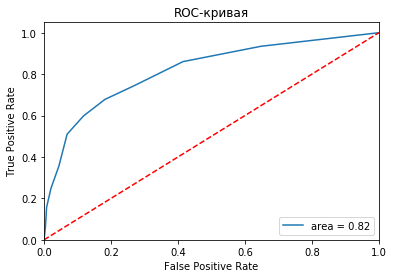

In [53]:
def show_roc_curve(model):
    probs = model.predict_proba(features_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(target_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='area = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right")
    plt.show()
    
show_roc_curve(best_clf)

Обучим сбалансированную модель DecisionTreeClassifier

In [54]:
f1, roc_auc, max_depth_decision_tree, model_tree = get_score_decision_tree_classifier(features_upsampled, target_upsampled, step=1)
print('f1_score',f1)        
print('roc_auc_score',roc_auc)     
print('max_depth_decision_tree',max_depth_decision_tree) 

f1_score 0.8731067837597047
roc_auc_score 0.8481777501256311
max_depth_decision_tree 5


Значение Дерева решений F1 получилось гораздо лучше чем до балансировки (0,649 против 0.873)

Обучим сбалансированную модель RandomForestClassifier

In [55]:
f1, roc_auc, n_estimators, random_forest_model = get_score_random_forest_classifier(features_upsampled,target_upsampled)
print('f1_score',f1)        
print('roc_auc_score',roc_auc)     
print('n_estimators',n_estimators)

f1_score 0.7119205298013246
roc_auc_score 0.8353440452677094
n_estimators 11


Значение F1 и здесь получилось лучше чем до балансировки

Обучим сбалансированную модель LogisticRegression

In [56]:
f1, roc_auc, threshold = get_score_logistic_regression(features_upsampled, target_upsampled)
print()        
print('f1_score',f1)        
print('roc_auc_score',roc_auc)     
print('threshold',threshold)

Порог = 0.00 | Точность = 0.723, Полнота = 1.000, f1 = 0.840
Порог = 0.02 | Точность = 0.723, Полнота = 1.000, f1 = 0.840
Порог = 0.04 | Точность = 0.723, Полнота = 1.000, f1 = 0.840
Порог = 0.06 | Точность = 0.723, Полнота = 1.000, f1 = 0.840
Порог = 0.08 | Точность = 0.723, Полнота = 1.000, f1 = 0.840
Порог = 0.10 | Точность = 0.723, Полнота = 1.000, f1 = 0.840
Порог = 0.12 | Точность = 0.724, Полнота = 1.000, f1 = 0.840
Порог = 0.14 | Точность = 0.724, Полнота = 1.000, f1 = 0.840
Порог = 0.16 | Точность = 0.724, Полнота = 1.000, f1 = 0.840
Порог = 0.18 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.20 | Точность = 0.726, Полнота = 1.000, f1 = 0.841
Порог = 0.22 | Точность = 0.728, Полнота = 1.000, f1 = 0.842
Порог = 0.24 | Точность = 0.729, Полнота = 0.997, f1 = 0.843
Порог = 0.26 | Точность = 0.732, Полнота = 0.997, f1 = 0.844
Порог = 0.28 | Точность = 0.734, Полнота = 0.992, f1 = 0.844
Порог = 0.30 | Точность = 0.737, Полнота = 0.989, f1 = 0.845
Порог = 0.32 | Точность 

Лучше чем до балансировки и с параметром class_weight='balanced'

### Вывод

По результатам обучения сбалансированных моделей лучший результат
показала модель DecisionTreeClassifier с max_depth = 5.
Её и будем использовать в дальнейшем.

# 4. Тестирование модели

Теперь протестируем модель на выборке которую она не видела. 

In [57]:
predicted_test = model_tree.predict(features_test)
f1 = f1_score(target_test, predicted_test)

probabilities_valid = model_tree.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_valid)
        
print('f1_score',f1)           
print('roc_auc',roc_auc)

f1_score 0.8525409608442098
roc_auc 0.8376068376068376


Результат предсказания и модели и на тестовой выборке выше чем 0,59 как нужно по заданию.   
f1_score 0.8525409608442098  
roc_auc 0.8376068376068376

## Итоговые выводы и результаты работы  
  
В начале работы подготовили и исследовали данные, при проверке по матрице корреляции,
выяснилась слабая корреляция в признаках 'Age' (Возраст) и 'Balance' (Баланс).
Так же классы оказались не сбалансированы. Тех кто остался в Бета-Банке 80% тех
кто ушел 20%. Это отразилось на дальнейшем ходе работы.
Категориальные классы закодировали числами методом get_dummies затем
привели все числовые признаки к одному масштабу.
После этого данные были готовы для обучения моделей.
Использовались модели классификации DecisionTreeClassifier,
 RandomForestClassifier, LogisticRegression
  
С начало обучили на несбалнсированных классах, результаты в таблице ниже,
 потом методом upsempling сбалансировали.

###### Модели ДО изменения баланса:
| Models                  | F1_score | AUC-ROC  | Best_hiperparam            |
| ----------------------- |---------:| --------:| --------------------------:|
| DecisionTreeClassifier  |   0.5099 |   0.7207 | max_depth_decision_tree 11 |
| RandomForestClassifier  |   0.5832 |   0.8611 |            n_estimators 41 |
| LogisticRegression      |   0.5068 |   0.7736 |             threshold 0.22 |

###### Модели ПОСЛЕ изменения баланса:
| Models                  | F1_score | AUC-ROC  | Best_hiperparam            |
| ----------------------- |---------:| --------:| --------------------------:|
| DecisionTreeClassifier  |   **0.8731** |   **0.8482** |  max_depth_decision_tree 5 |
| RandomForestClassifier  |   0.7119 |   0.8353 |            n_estimators 11 |
| LogisticRegression      |   0.8532 |   0.7793 |             threshold 0.58 |
| LogisticRegression (bal)|   0.5146 |   0.7777 |             threshold 0.54 |



В результаты работы лучшая модель на тесте DecisionTreeClassifier по
характеристикам F1_score = 0.8525, Площадь под Roc_Auc = 0.8376 при глубине 5.
Посмотрим на график AUC-ROC.

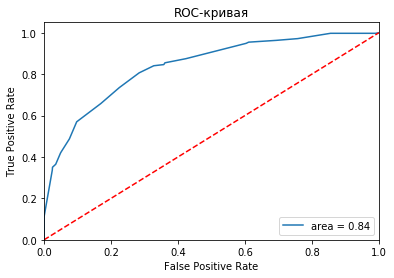

In [58]:
show_roc_curve(model_tree)

Судя по графику модель далека от случайной, площадь которой была бы равна 0,5